# New York City Motor Vehicle Collisions
GitHub Repository: https://github.com/skhiearth/NYC-Motor-Vehicle-Collisions

Kaggle Kernel: https://www.kaggle.com/skhiearth/nyc-motor-vehicle-collisions (Uses a smaller dataset)

**Analysing and visualising Motor Vehicle Collisions in New York City with an objective to make the city roads safer using Data Science techniques. The [dataset](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) used is provided by NYC Open Data and contains details on the crash event. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC.**

In [137]:
# Import the required packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd

### Importing data

Download the static file from [here](https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD). Dynamic data can be fetched using the Socrata Open Data API (SODA). 
Note that SODA limits a single API call to 1000 rows, so please use the offset parameter to make multiple API calls
to fetch all rows.
The exact static file version used here has been uploaded to Google Drive, and made public. You may access this version from [here](https://drive.google.com/open?id=1Wv9yya3u3HjnP2XZbxouFUnyLD4plU4Y).

In [2]:
# Importing static dataset from .csv file
raw_data = pd.read_csv('datasets/Motor_Vehicle_Collisions_-_Crashes.csv')

print(raw_data.shape)
raw_data.head(3)

(904482, 29)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/02/2016,22:23,BRONX,10456.0,NaN,NaN,NaN,WESTCHESTER AVENUE,UNION AVENUE,NaN,...,NaN,NaN,NaN,NaN,3411047.0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
1,01/06/2020,12:50,NaN,NaN,NaN,NaN,NaN,PRINCE STREET,NaN,NaN,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,4269674.0,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
2,01/06/2020,13:16,MANHATTAN,10018.0,NaN,NaN,NaN,40 STREET,12 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4269909.0,Sedan,Bus,NaN,NaN,NaN


### Data Pre-processing and Cleaning

In [3]:
# Removing columns that have more than a third values as NaN
mask = raw_data.isna().sum() / len(raw_data) < 0.34
raw_data = raw_data.loc[:, mask]

# Removing columns that don't have a large contributing factor to EDA and Predictions
cols_to_drop = ['ZIP CODE', 'LOCATION', 
                'CONTRIBUTING FACTOR VEHICLE 2', 'VEHICLE TYPE CODE 2']
raw_data.drop(cols_to_drop, axis = 1, inplace = True)

In [4]:
# Concatenating date and time columns
raw_data['CRASH_DATE_TIME'] = raw_data['CRASH DATE'] + ' ' + raw_data['CRASH TIME']

# Drop redundant date and time columns
cols_to_drop = ['CRASH DATE', 'CRASH TIME']
raw_data.drop(cols_to_drop, axis = 1, inplace = True)

In [5]:
# Convert Crash Date and time to datetime format
raw_data['CRASH_DATE_TIME']= pd.to_datetime(raw_data['CRASH_DATE_TIME'], 
                                            dayfirst=True, errors='coerce')

# Dropping rows with problematics dates
idx = raw_data[raw_data['CRASH_DATE_TIME'].isnull()].index
raw_data.drop(idx, axis = 0, inplace = True)

print(raw_data.shape)
raw_data.head(3)

(904477, 16)


,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CRASH_DATE_TIME
0,BRONX,NaN,NaN,WESTCHESTER AVENUE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Driver Inattention/Distraction,3411047.0,PASSENGER VEHICLE,2016-02-04 22:23:00
1,NaN,NaN,NaN,PRINCE STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lane Marking Improper/Inadequate,4269674.0,Sedan,2020-06-01 12:50:00
2,MANHATTAN,NaN,NaN,40 STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Following Too Closely,4269909.0,Sedan,2020-06-01 13:16:00


### Borough-wise Analysis

In [6]:
borough_wise = raw_data.groupby(['BOROUGH']).size().reset_index(name='NoOfAccidents')
borough_wise.head()

,BOROUGH,NoOfAccidents
0,BRONX,89247
1,BROOKLYN,189648
2,MANHATTAN,133376
3,QUEENS,164321
4,STATEN ISLAND,22822


The [GIS data](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm) with the Boundaries of Boroughs for New York City is obtained from NYC Open Data. The data is provided by the Department of City Planning (DCP).

In [7]:
# Import the ShapeFile for Borough Boundaries
fp = 'datasets/Borough Boundaries/geo_export_87071461-9196-46f3-8d1b-52fed88fb835.shp'
borough_geo = gpd.read_file(fp)
borough_geo['boro_name'] = borough_geo['boro_name'].str.upper() 

# Merging ShapeFile with data
borough_wise = borough_geo.set_index('boro_name').join(borough_wise.set_index('BOROUGH'))

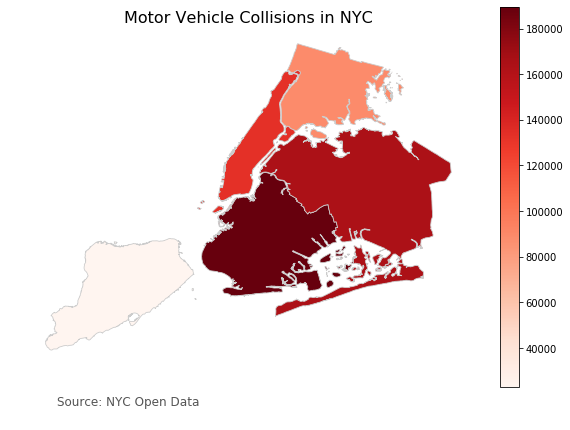

In [8]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 7))

# Drawing the Map
borough_wise.plot(column = 'NoOfAccidents', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax, edgecolor = '0.8')

# Map customizations
ax.axis('off')
ax.set_title('Motor Vehicle Collisions in NYC', size = 16)
ax.annotate('Source: NYC Open Data', xy = (0.1, .08),  
            xycoords = 'figure fraction', horizontalalignment = 'left', verticalalignment = 'top', 
            fontsize = 12, color = '#555555')

# Adding a color bar legend to the map
sm = plt.cm.ScalarMappable(cmap = 'Reds', 
                           norm = plt.Normalize(vmin = 22822, vmax = 189648))
cbar = fig.colorbar(sm)

# Export map
fig.savefig('plots/borough_wise_accidents.png', dpi=300)

**Analysis: Brooklyn and Queens have reported a very high number of accidents. On the other hand, Staten Island reported the least number of accidents in New York City boroughs.**

In [9]:
injuries_and_fatalities = raw_data.groupby(['BOROUGH'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

injuries_and_fatalities['Total Accidents'] = raw_data.groupby(['BOROUGH']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# Injuries and Fatalities as Percentages
injuries_and_fatalities['Injury%'] = round((injuries_and_fatalities['NUMBER OF PERSONS INJURED']\
/ injuries_and_fatalities['Total Accidents'] * 100), 1)
injuries_and_fatalities['Fatality%'] = round((injuries_and_fatalities['NUMBER OF PERSONS KILLED']\
/ injuries_and_fatalities['Total Accidents'] * 100), 3)

injuries_and_fatalities.head()

,BOROUGH,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
0,BRONX,75.0,24820.0,89247,27.8,0.084
1,BROOKLYN,206.0,52861.0,189648,27.9,0.109
2,MANHATTAN,101.0,23188.0,133376,17.4,0.076
3,QUEENS,181.0,43231.0,164321,26.3,0.110
4,STATEN ISLAND,35.0,5833.0,22822,25.6,0.153


In [10]:
# Dropping redudant column and merging with ShapeFile
injuries_and_fatalities.drop('Total Accidents', axis = 1, inplace = True)
injuries_and_fatalities = borough_geo.set_index('boro_name').join(injuries_and_fatalities.set_index('BOROUGH'))

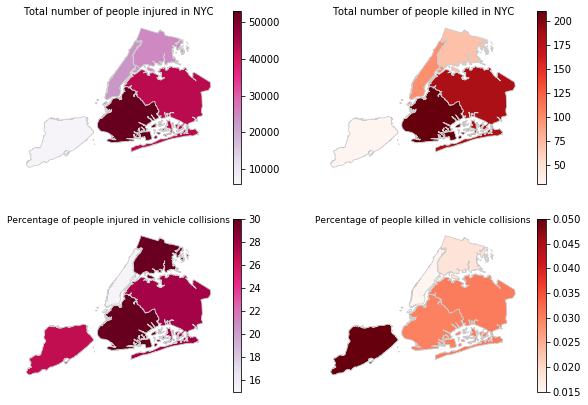

In [11]:
# Create figure and axes for Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 7))

# Drawing the maps
injuries_and_fatalities.plot(column = 'NUMBER OF PERSONS INJURED', cmap = 'PuRd', linewidth = 0.8, 
                      ax = ax1, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'NUMBER OF PERSONS KILLED', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax2, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'Injury%', cmap = 'PuRd', linewidth = 0.8, 
                      ax = ax3, edgecolor = '0.8')
injuries_and_fatalities.plot(column = 'Fatality%', cmap = 'Reds', linewidth = 0.8, 
                      ax = ax4, edgecolor = '0.8')

# Map customizations
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax1.set_title('Total number of people injured in NYC', size = 10)
ax2.set_title('Total number of people killed in NYC', size = 10)
ax3.set_title('Percentage of people injured in vehicle collisions', size = 9)
ax4.set_title('Percentage of people killed in vehicle collisions', size = 9)

# Adding color bar legends to the maps
sm = plt.cm.ScalarMappable(cmap = 'PuRd', norm = plt.Normalize(vmin = 5800, vmax = 53000))
cbar = fig.colorbar(sm, ax = ax1)

sm = plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = 30, vmax = 210))
cbar = fig.colorbar(sm, ax = ax2)

sm = plt.cm.ScalarMappable(cmap = 'PuRd', norm = plt.Normalize(vmin = 15, vmax = 30))
cbar = fig.colorbar(sm, ax = ax3)

sm = plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = 0.05, vmax = 0.015))
cbar = fig.colorbar(sm, ax = ax4)

# Export map
fig.savefig('plots/borough_wise_injury_percentage.png', dpi=500)

**Analysis: Brooklyn and Bronx have reported a very high percentage of accidents that result in injury. Queens and Staten Island also have a very high percentage, third and fourth to the first two borough by only a couple of percentages. On the other hand, Manhattan reported the least number of accidents in New York City boroughs.**

### Contributing Factor Analysis

In the dataset, the column `CONTRIBUTING FACTOR VEHICLE 1` gives the factor contributing to the collision for designated vehicle. 

In [203]:
# Calculate the number of people killed, injured and total accidents for each contributing factor
factor_wise = raw_data.groupby(['CONTRIBUTING FACTOR VEHICLE 1'])\
['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED'].agg('sum').reset_index()

factor_wise['Total Accidents'] = raw_data.groupby(['CONTRIBUTING FACTOR VEHICLE 1']).size().\
reset_index(name='NoOfAccidents').NoOfAccidents

# 'Unspecified' factor is the most common factor in motor vehicle collissions reported by the NYPD, 
# but since these don't give us any concrete analysis, we won't consider this, and hence we drop it.
factor_wise = factor_wise.sort_values('Total Accidents', ascending = False).head(10).iloc[1:]

# Injuries and Fatalities as Percentages
factor_wise['Injury%'] = round((factor_wise['NUMBER OF PERSONS INJURED']/factor_wise['Total Accidents'] * 100), 1)
factor_wise['Fatality%'] = round((factor_wise['NUMBER OF PERSONS KILLED']/factor_wise['Total Accidents'] * 100), 3)

# Drop last two
factor_wise = factor_wise[:-1]
factor_wise.head(3)

,CONTRIBUTING FACTOR VEHICLE 1,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
11,Driver Inattention/Distraction,139.0,55953.0,203436,27.5,0.068
21,Following Too Closely,7.0,21137.0,66711,31.7,0.010
18,Failure to Yield Right-of-Way,101.0,25941.0,59170,43.8,0.171


#### Most common reasons for accidents:

In [88]:
factor_accidents = factor_wise.sort_values('Total Accidents', ascending = False).head(10)
factor_accidents.head(3)

,CONTRIBUTING FACTOR VEHICLE 1,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED,Total Accidents,Injury%,Fatality%
56,Unspecified,277.0,54265.0,244397,22.2,0.113
11,Driver Inattention/Distraction,139.0,55953.0,203436,27.5,0.068
21,Following Too Closely,7.0,21137.0,66711,31.7,0.010


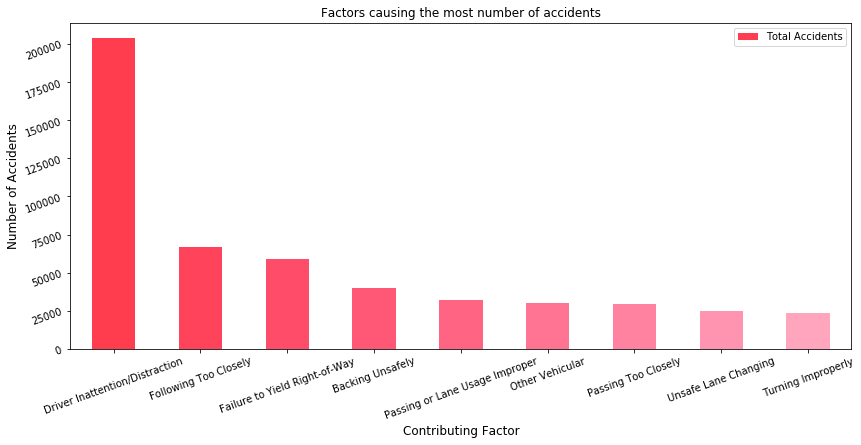

In [210]:
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 6))

# Defining color map
color = np.flip(cm.Reds(np.linspace(.2,.6, 10)))

# Creating the plot
factor_accidents.plot(x = 'CONTRIBUTING FACTOR VEHICLE 1', 
                      y = 'Total Accidents', kind = 'bar', 
                      color = color, stacked = True, ax = ax)

# Customizing the Visulation
ax.set_title('Factors causing the most number of accidents', size = 12)
ax.set_xlabel('Contributing Factor', size = 12)
ax.set_ylabel('Number of Accidents', size = 12)
ax.tick_params(labelrotation = 20)

# Exporting the visualisation
fig.savefig('plots/factor_accidents.png', dpi=500)

**Analysis: Driver Distraction is by far the most common factor leading to accidents on the roads of New York City. This is a strong argument in favor of the promotion of self-driving cars to make our roads safer.**

#### Contributing Factors with highest injury and fatality rate:

In [204]:
factor_inj_rate = factor_wise.sort_values('Injury%', ascending = False).head(10)
factor_fat_rate = factor_wise.sort_values('Fatality%', ascending = False).head(10)

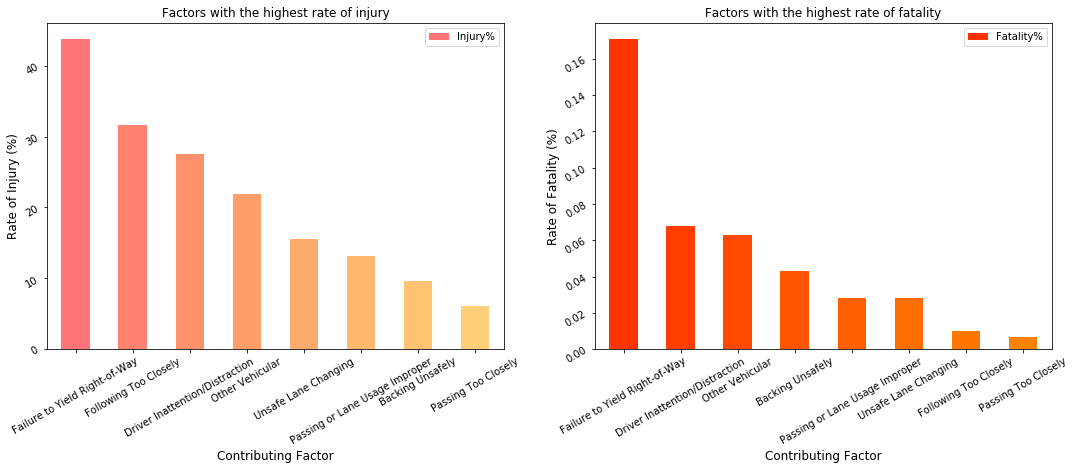

In [221]:
# Create figure and axes for Matplotlib
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Defining color map
color = np.flip(cm.plasma(np.linspace(.2,.6, 10)))
color2 = cm.autumn(np.linspace(.2,.6, 10))

# Creating the plots
factor_inj_rate.plot(x = 'CONTRIBUTING FACTOR VEHICLE 1', 
                      y = 'Injury%', kind = 'bar', 
                      color = color, stacked = True, ax = ax1)

factor_fat_rate.plot(x = 'CONTRIBUTING FACTOR VEHICLE 1', 
                      y = 'Fatality%', kind = 'bar', 
                      color = color2, stacked = True, ax = ax2)

# Customizing the Visulation
ax1.set_title('Factors with the highest rate of injury', size = 12)
ax1.set_xlabel('Contributing Factor', size = 12)
ax1.set_ylabel('Rate of Injury (%)', size = 12)
ax1.tick_params(labelrotation = 30)

ax2.set_title('Factors with the highest rate of fatality', size = 12)
ax2.set_xlabel('Contributing Factor', size = 12)
ax2.set_ylabel('Rate of Fatality (%)', size = 12)
ax2.tick_params(labelrotation = 30)

# Exporting the visualisation
fig.savefig('plots/factor_inj_fat_rate.png', dpi=500)